In [43]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import scale, robust_scale
from sklearn.decomposition import PCA
from sklearn.cross_validation import KFold, cross_val_score
%matplotlib inline

/home/dockeruser/anaconda2/envs/gl-env/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 2. Preprocessing & Modeling

1. Scale
2. Robust Scale
3. Feature Engineering, 데이터마다 각각 전처리 다르게 적용
4. PCA


In [4]:
# Load the Dataset
X = pd.read_csv('train.csv')

X.tail()

,Season,NAT,Club_Name,TSR,STR,PDO,Pass_Success,Possesion,Team_Value,AGE,FPPsq,Country Score,Rating,Pts
476,1516,GER,Wolfsburg,0.551852,0.560662,893.8322,0.820588,0.578824,7.58,24.5,0.542857,79.415,6.85,56.035
477,1516,GER,Eintracht Frankfurt,0.458194,0.439859,953.9767,0.721765,0.471765,2.50,23.9,0.571429,79.415,6.69,28.035
478,1516,GER,Borussia,0.493404,0.536775,949.0774,0.795152,0.556667,4.81,24.4,0.586207,79.415,6.94,42.035
479,1516,GER,Mainz 05,0.445851,0.466027,946.8986,0.720000,0.461471,1.73,24.3,0.564103,79.415,6.84,18.035
480,1516,GER,Augsburg,0.437485,0.446503,1082.3060,0.747647,0.468824,1.60,24.9,0.512821,79.415,6.80,23.035


In [5]:
#변수로 쓰지 않을 column 제거
del X["Season"]
del X["NAT"]
del X["Club_Name"]
X.tail()

,TSR,STR,PDO,Pass_Success,Possesion,Team_Value,AGE,FPPsq,Country Score,Rating,Pts
476,0.551852,0.560662,893.8322,0.820588,0.578824,7.58,24.5,0.542857,79.415,6.85,56.035
477,0.458194,0.439859,953.9767,0.721765,0.471765,2.50,23.9,0.571429,79.415,6.69,28.035
478,0.493404,0.536775,949.0774,0.795152,0.556667,4.81,24.4,0.586207,79.415,6.94,42.035
479,0.445851,0.466027,946.8986,0.720000,0.461471,1.73,24.3,0.564103,79.415,6.84,18.035
480,0.437485,0.446503,1082.3060,0.747647,0.468824,1.60,24.9,0.512821,79.415,6.80,23.035


In [6]:
# 실제 X Feature로 쓸 Feature 변수, Target 값, 데이터 수 표현 
dfX0 = X[[x for x in [0,1,2,3,4,5,6,7,8,9]]]
dfy = X[['Pts']]
dfX0.head()
len(dfy) # 데이터 수

481

## Case 1 : 데이터 전처리를 Scale 방법으로 했을 때 

* OLS분석의 귀무가설:
    * P-value > 0.05 = 가중치가 0이라고 봐도 무방하다. (즉, 그런 변수는 이 모델에 아무런 영향도 주지 않는다.)

In [7]:
dfX_1 = scale(dfX0)
y = X['Pts']

X_1 = pd.DataFrame(dfX_1, columns = ["TSR", "STR", "PDO", "Pass_Success", "Possesion", 
                                     "Team_Value", "AGE", "FPPsq", "Country Score", "Rating"])
X_1.head()

,TSR,STR,PDO,Pass_Success,Possesion,Team_Value,AGE,FPPsq,Country Score,Rating
0,1.767694,1.072830,0.702958,0.633235,1.155129,1.761684,0.519319,1.123764,0.705245,2.090819
1,2.360454,2.498766,0.477391,-0.796171,1.778369,3.074054,1.975362,1.428731,0.705245,2.868828
2,1.785834,1.186252,0.240562,0.824346,1.445852,0.473668,-2.150094,1.266081,0.705245,1.949362
3,1.012133,0.504223,0.357675,-0.304279,0.055262,0.430373,-0.855833,-0.021720,0.705245,2.090819
4,1.528923,0.223077,0.064519,0.101769,1.227801,1.821215,0.033971,1.977668,0.705245,1.029896


In [8]:
dfX_c = sm.add_constant(X_1)
model = sm.OLS(y, dfX_c)
result = model.fit()
print (result.summary())

                            OLS Regression Results                            
Dep. Variable:                    Pts   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     141.6
Date:                Mon, 26 Dec 2016   Prob (F-statistic):          6.25e-135
Time:                        06:20:11   Log-Likelihood:                -2090.5
No. Observations:                 481   AIC:                             4203.
Df Residuals:                     470   BIC:                             4249.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const            51.1599      0.861     59.394

* 모든 데이터 전처리를 Scale 방법으로 했을 때 

    * 성능(R-squared)은 0.751로 75%정도 설명할 수 있다.
    * PDO, Pass_Success, Possesion, FPPsq의 P-value가 귀무가설에 만족하므로 영향을 주지 않는 변수라고 나온다.
    * Omnibus, Jarque-Bera를 통한 정규성 검정 결과 P-value가 유의수준 0.05미만이므로 정규성을 따르지 않는다.
---    
    
    => 전처리 방법을 바꿔야 한다.

## Case 2 : 데이터 전처리를 Robust Scale 방법으로 했을 때 


In [9]:
dfX_2 = robust_scale(dfX0)
y = X['Pts']

X_2 = pd.DataFrame(dfX_1, columns = ["TSR", "STR", "PDO", "Pass_Success", "Possesion", 
                                     "Team_Value", "AGE", "FPPsq", "Country Score", "Rating"])
X_2.head()

,TSR,STR,PDO,Pass_Success,Possesion,Team_Value,AGE,FPPsq,Country Score,Rating
0,1.767694,1.072830,0.702958,0.633235,1.155129,1.761684,0.519319,1.123764,0.705245,2.090819
1,2.360454,2.498766,0.477391,-0.796171,1.778369,3.074054,1.975362,1.428731,0.705245,2.868828
2,1.785834,1.186252,0.240562,0.824346,1.445852,0.473668,-2.150094,1.266081,0.705245,1.949362
3,1.012133,0.504223,0.357675,-0.304279,0.055262,0.430373,-0.855833,-0.021720,0.705245,2.090819
4,1.528923,0.223077,0.064519,0.101769,1.227801,1.821215,0.033971,1.977668,0.705245,1.029896


In [10]:
dfX_c2 = sm.add_constant(X_2)
model = sm.OLS(y, dfX_c2)
result = model.fit()
print (result.summary())

                            OLS Regression Results                            
Dep. Variable:                    Pts   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     141.6
Date:                Mon, 26 Dec 2016   Prob (F-statistic):          6.25e-135
Time:                        06:20:33   Log-Likelihood:                -2090.5
No. Observations:                 481   AIC:                             4203.
Df Residuals:                     470   BIC:                             4249.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const            51.1599      0.861     59.394

* 모든 데이터 전처리를 Robust Scale 방법으로 했을 때 

    * 성능(R-squared)은 0.751로 75%정도 설명할 수 있다.
    * PDO, Pass_Success, Possesion, FPPsq의 P-value가 귀무가설에 만족하므로 영향을 주지 않는 변수라고 나온다.
    * Omnibus, Jarque-Bera를 통한 정규성 검정 결과 P-value가 유의수준 0.05미만이므로 정규성을 따르지 않는다.
---    
    
    => 전처리 방법을 바꿔야 한다.

## Case3 : Feature Engineering, 데이터 마다 각각 전처리 방법을 다르게 했을 경우

* 데이터마다 각각 전처리 방법 다르게 했을 때(scale, robust_scale, minmax_scale, maxabs_scale)
* Heatmap, Pairplot을 참고했을 때 상관관계가 있는 변수들은 그 중에 하나씩 제거해보면서 OLS 분석

In [20]:
dfX0 = X[[x for x in [0,1,2,3,4,5,6,7,8,9]]]
dfy = X[['Pts']]

dfX0.head()

,TSR,STR,PDO,Pass_Success,Possesion,Team_Value,AGE,FPPsq,Country Score,Rating
0,0.628058,0.611384,1052.258,0.800789,0.581842,11.00,25.0,0.666667,79.499,7.19
1,0.680405,0.720911,1035.715,0.737797,0.615692,15.85,26.8,0.714286,79.499,7.30
2,0.629660,0.620096,1018.346,0.809211,0.597632,6.24,21.7,0.688889,79.499,7.17
3,0.561334,0.567709,1026.935,0.759474,0.522105,6.08,23.3,0.487805,79.499,7.19
4,0.606972,0.546114,1005.435,0.777368,0.585789,11.22,24.4,0.800000,79.499,7.04


### 3- 1 (TSR, PDO, Pass_Success, Team_value, AGE, FPPsq, Country_Score)  Feature로 선택
### target = np.log(X['Pts'])

In [21]:
robust_tsr = robust_scale(dfX0['TSR'])
robust_pdo = robust_scale(dfX0['PDO'])
scale_Pass = scale(dfX0['Pass_Success'])
log_T_V = np.log(dfX0['Team_Value'])
scale_age = scale(dfX0['AGE'])
robust_FPPsq = robust_scale(dfX0['FPPsq'])
scale_C_S = scale(dfX0['Country Score'])
target = np.log(X['Pts'])

/home/dockeruser/anaconda2/envs/gl-env/lib/python2.7/site-packages/sklearn/preprocessing/data.py:986: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/dockeruser/anaconda2/envs/gl-env/lib/python2.7/site-packages/sklearn/preprocessing/data.py:1008: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/dockeruser/anaconda2/envs/gl-env/lib/python2.7/site-packages/sklearn/preprocessing/data.py:986: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Resh

In [22]:
case1_array = np.array([robust_tsr, robust_pdo, scale_Pass, log_T_V, scale_age, robust_FPPsq, scale_C_S]).T

In [23]:
case_1 = pd.DataFrame(case1_array, columns = ['TSR', 'PDO', 'Pass_Success', 'Team_Value', 
                                              'AGE' ,'FPPsq','Country Score'])

In [24]:
case_1.head()

,TSR,PDO,Pass_Success,Team_Value,AGE,FPPsq,Country Score
0,1.162793,0.669332,0.633235,2.397895,0.519319,0.948275,0.705245
1,1.574213,0.465196,-0.796171,2.763170,1.975362,1.219211,0.705245
2,1.175384,0.250868,0.824346,1.830980,-2.150094,1.074711,0.705245
3,0.638378,0.356854,-0.304279,1.805005,-0.855833,-0.069385,0.705245
4,0.997068,0.091550,0.101769,2.417698,0.033971,1.706892,0.705245


In [25]:
case_1_constant = sm.add_constant(case_1)
model = sm.OLS(target, case_1_constant)
result = model.fit()
print (result.summary())

                            OLS Regression Results                            
Dep. Variable:                    Pts   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     143.0
Date:                Mon, 26 Dec 2016   Prob (F-statistic):          1.90e-112
Time:                        06:22:19   Log-Likelihood:                -268.96
No. Observations:                 481   AIC:                             553.9
Df Residuals:                     473   BIC:                             587.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const             2.7518      0.054     51.306

* TSR, PDO, Pass_Success, Team_value, AGE, FPPsq, Country_Score를 Feature로 선택했을 때

    * 성능은 0.679, 약 68%정도로 감소하였지만 Feature들의 P-value 값들이 전보다 많이 좋아졌음을 알 수 있다.
    * PDO, Pass_Success FPPsq 변수의 p-value들이 OLS의 귀무가설을 만족하여 영향을 주지 않는 변수로 나온다.
    * 정규성 검정을 보면 p-value가 0.05이상이므로 정규성을 따른다.
    * 다중공선성을 따르지 않는다.
    
---
=> 다른 변수들도 선택하면서 분석해보자.

### 3- 2 (STR, PDO, Possesion, Team_value, AGE, FPPsq, Country_Score Feature) Feature로 선택
### target = np.log(X['Pts'])

In [26]:
robust_str = robust_scale(dfX0['STR'])
robust_pdo = robust_scale(dfX0['PDO'])
scale_Poss = scale(dfX0['Possesion'])
log_T_V = np.log(dfX0['Team_Value'])
scale_age = scale(dfX0['AGE'])
robust_FPPsq = robust_scale(dfX0['FPPsq'])
scale_C_S = scale(dfX0['Country Score'])
target = np.log(X['Pts'])

/home/dockeruser/anaconda2/envs/gl-env/lib/python2.7/site-packages/sklearn/preprocessing/data.py:986: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/dockeruser/anaconda2/envs/gl-env/lib/python2.7/site-packages/sklearn/preprocessing/data.py:1008: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/dockeruser/anaconda2/envs/gl-env/lib/python2.7/site-packages/sklearn/preprocessing/data.py:986: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Resh

In [27]:
case2_array = np.array([robust_str, robust_pdo, scale_Poss, log_T_V, scale_age, robust_FPPsq, scale_C_S]).T
case_2 = pd.DataFrame(case2_array, columns = ['STR', 'PDO', 'Possesion', 'Team_Value', 
                                              'AGE' ,'FPPsq','Country Score'])

In [28]:
case_2_constant = sm.add_constant(case_2)
model = sm.OLS(target, case_2_constant)
result = model.fit()
print (result.summary())

                            OLS Regression Results                            
Dep. Variable:                    Pts   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     143.8
Date:                Mon, 26 Dec 2016   Prob (F-statistic):          7.78e-113
Time:                        06:22:30   Log-Likelihood:                -268.05
No. Observations:                 481   AIC:                             552.1
Df Residuals:                     473   BIC:                             585.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const             2.8571      0.052     54.681

* STR, PDO, Possesion, Team_value, AGE, FPPsq, Country_Score를 Feature로 선택했을 경우

    * R-squared(성능) 값은 0.680, 즉 이 모델은 68%정도 설명할 수 있다.
    * Feature들의 p-value 값을 보면 Posession과 FPPsq는 이 모델에 영향을 주지 않는 변수로 나온다.
    * 정규성을 따른다.
    * 다중공선성이 발생하지 않는다.
---

=> 아직 만족스럽지 않아서 Feature들을 다시 선택해보고 분석해보자.   

### 3- 3 (TSR, PDO, Pass_Success, Team_value, AGE, Country_Score) Feature로 선택
### target = np.log(X['Pts'])

In [29]:
robust_tsr = robust_scale(dfX0['TSR'])
robust_pdo = robust_scale(dfX0['PDO'])
scale_Pass = scale(dfX0['Pass_Success'])
log_T_V = np.log(dfX0['Team_Value'])
scale_age = scale(dfX0['AGE'])
scale_C_S = scale(dfX0['Country Score'])
target = np.log(X['Pts'])

/home/dockeruser/anaconda2/envs/gl-env/lib/python2.7/site-packages/sklearn/preprocessing/data.py:986: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/dockeruser/anaconda2/envs/gl-env/lib/python2.7/site-packages/sklearn/preprocessing/data.py:1008: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/dockeruser/anaconda2/envs/gl-env/lib/python2.7/site-packages/sklearn/preprocessing/data.py:986: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Resh

In [30]:
case3_array = np.array([robust_tsr, robust_pdo, scale_Pass, log_T_V, scale_age, scale_C_S]).T
case_3 = pd.DataFrame(case3_array, columns = ['TSR', 'PDO', 'Pass_Success', 'Team_Value', 
                                              'AGE' ,'Country Score'])

In [31]:
case_3_constant = sm.add_constant(case_3)
model = sm.OLS(target, case_3_constant)
result = model.fit()
print (result.summary())

                            OLS Regression Results                            
Dep. Variable:                    Pts   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     166.0
Date:                Mon, 26 Dec 2016   Prob (F-statistic):          4.32e-113
Time:                        06:22:59   Log-Likelihood:                -270.10
No. Observations:                 481   AIC:                             554.2
Df Residuals:                     474   BIC:                             583.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const             2.7539      0.054     51.296

* TSR, PDO, Pass_Success, Team_value, AGE, Country_Score를 Feature로 선택했을 경우
    * R-squared(성능)값은 0.678로 살짝 낮아졌다.
    * Feature들의 p-value를 살펴보면 Pass_Success와 PDO가 이 모델에 영향을 주지 않는 변수이다.
    * 정규성을 따른다.
    * 다중공선성이 발생하지 않았다.
    * 전체적으로 Feature들의 p-value가 점점 나아지고 있지만 아직 만족스럽지 못하다.
---
=> 다른 Feature들을 선택해보면서 계속 분석해보자.


### 3- 4 (TSR, PDO, Team_value, AGE, FPPsq, Country_Score)를 Feature로 선택
### target = np.log(X['Pts'])

In [32]:
robust_tsr = robust_scale(dfX0['TSR'])
robust_pdo = robust_scale(dfX0['PDO'])
log_T_V = np.log(dfX0['Team_Value'])
scale_age = scale(dfX0['AGE'])
robust_FPPsq = robust_scale(dfX0['FPPsq'])
scale_C_S = scale(dfX0['Country Score'])
target = np.log(X['Pts'])

/home/dockeruser/anaconda2/envs/gl-env/lib/python2.7/site-packages/sklearn/preprocessing/data.py:986: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/dockeruser/anaconda2/envs/gl-env/lib/python2.7/site-packages/sklearn/preprocessing/data.py:1008: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/dockeruser/anaconda2/envs/gl-env/lib/python2.7/site-packages/sklearn/preprocessing/data.py:986: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Resh

In [33]:
case4_array = np.array([robust_tsr, robust_pdo, log_T_V, scale_age, robust_FPPsq, scale_C_S]).T
case_4 = pd.DataFrame(case4_array, columns = ['TSR', 'PDO', 'Team_Value', 
                                              'AGE' ,'FPPsq','Country Score'])

In [34]:
case_4_constant = sm.add_constant(case_4)
model = sm.OLS(target, case_4_constant)
result = model.fit()
print (result.summary())

                            OLS Regression Results                            
Dep. Variable:                    Pts   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     166.0
Date:                Mon, 26 Dec 2016   Prob (F-statistic):          4.14e-113
Time:                        06:23:28   Log-Likelihood:                -270.06
No. Observations:                 481   AIC:                             554.1
Df Residuals:                     474   BIC:                             583.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const             2.7238      0.050     54.254

* TSR, PDO, Team_value, AGE, FPPsq, Country_Score를 Feature로 선택했을 경우

    * R-squared(성능)값은 0.678로 이전과 동일하다.
    * Feature들의 p-value를 살펴보면 FPPsq만 이 모델에서 영향을 주지 않는 변수로 나타난다.
    * 전체적으로 성능이 좋아졌다.
    * 정규성을 따르고 다중공선성이 나타나지 않았다.
    
---

=> FPPsq를 빼보고 OLS분석을 해보자.

### 3- 5 TSR, PDO, Team_value, AGE,  Country_Score만 Feature 변수로 선택
### target = np.log(X['Pts'])

In [35]:
robust_tsr = robust_scale(dfX0['TSR'])
robust_pdo = robust_scale(dfX0['PDO'])
log_T_V = np.log(dfX0['Team_Value'])
scale_age = scale(dfX0['AGE'])
scale_C_S = scale(dfX0['Country Score'])
target = np.log(X['Pts'])

/home/dockeruser/anaconda2/envs/gl-env/lib/python2.7/site-packages/sklearn/preprocessing/data.py:986: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/dockeruser/anaconda2/envs/gl-env/lib/python2.7/site-packages/sklearn/preprocessing/data.py:1008: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/dockeruser/anaconda2/envs/gl-env/lib/python2.7/site-packages/sklearn/preprocessing/data.py:986: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Resh

In [36]:
case5_array = np.array([robust_tsr, robust_pdo, log_T_V, scale_age, scale_C_S]).T
case_5 = pd.DataFrame(case5_array, columns = ['TSR', 'PDO', 'Team_Value', 
                                              'AGE' ,'Country Score'])

In [37]:
case_5_constant = sm.add_constant(case_5)
model = sm.OLS(target, case_5_constant)
result = model.fit()
print (result.summary())

                            OLS Regression Results                            
Dep. Variable:                    Pts   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     198.2
Date:                Mon, 26 Dec 2016   Prob (F-statistic):          8.72e-114
Time:                        06:24:10   Log-Likelihood:                -271.22
No. Observations:                 481   AIC:                             554.4
Df Residuals:                     475   BIC:                             579.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const             2.7256      0.050     54.233

* TSR, PDO, Team_value, AGE, Country_Score만 Feature 변수로 선택 했을 때

    * R-squared 값은 약간 떨어지긴 했지만 
      P-value도 안정적,
      Omnibus, Jarque-Bera를 통한 정규성 검정에서도 무리없이 통과 된 것을 알 수 있다.
      
    * Condition No.도 6.02로 낮아져서 다중공선성이 발생하지 않은 것으로 볼 수 있다.
    * Case 1~3-5까지 분석해본 결과 Case 3-5의 결과가 가장 나은 것을 알 수 있다.


# Case4 : PCA 이용

* Preprocessing Method : Scale

### PCA 사용 목적
* 각 변수들의 정보들을 최대한 이용하기 위해 PCA를 사용

In [38]:
# Scale
Scale_data = scale(dfX0)
dfX0.head()

,TSR,STR,PDO,Pass_Success,Possesion,Team_Value,AGE,FPPsq,Country Score,Rating
0,0.628058,0.611384,1052.258,0.800789,0.581842,11.00,25.0,0.666667,79.499,7.19
1,0.680405,0.720911,1035.715,0.737797,0.615692,15.85,26.8,0.714286,79.499,7.30
2,0.629660,0.620096,1018.346,0.809211,0.597632,6.24,21.7,0.688889,79.499,7.17
3,0.561334,0.567709,1026.935,0.759474,0.522105,6.08,23.3,0.487805,79.499,7.19
4,0.606972,0.546114,1005.435,0.777368,0.585789,11.22,24.4,0.800000,79.499,7.04


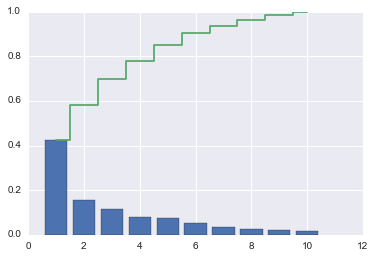

In [39]:
# 성분수의 결정
A = np.array(Scale_data) 
pca = PCA().fit(A)
var = pca.explained_variance_
cmap = sns.color_palette()
plt.bar(np.arange(1,len(var)+1), var/np.sum(var), align="center", color=cmap[0])
plt.step(np.arange(1,len(var)+1), np.cumsum(var)/np.sum(var), where="mid", color=cmap[1])
plt.show()
# PC5 까지 성분수 결정

In [40]:
# 성분수들의 결정계수들의 합 : 0.8이상이면 분석이 가능하다고 가정하에 진행
pca = PCA(n_components=5).fit(A)
k = (pca.explained_variance_ratio_) 
print (k[:5].sum())

0.851989243246


In [41]:
#각 PC1, PC2, PC3, PC4, PC5의 고유벡터들을 나타내었다.
pca.components_.T.shape
soccer_PCA_analysis = pd.DataFrame(pca.components_.T, 
                                   columns = ["PC1", "PC2", "PC3", "PC4", "PC5"], 
                                   index = dfX0.columns)
soccer_PCA_analysis

,PC1,PC2,PC3,PC4,PC5
TSR,0.320913,-0.276918,-0.444801,0.079760,-0.086319
STR,0.411223,0.162802,-0.016865,0.144534,-0.174635
PDO,0.208648,0.294922,0.517871,-0.228252,0.601846
Pass_Success,0.394824,0.138201,-0.096569,0.117614,0.151686
Possesion,0.420964,0.145239,-0.062862,0.146547,-0.028692
Team_Value,0.400406,-0.214424,0.176314,-0.038025,-0.177763
AGE,-0.011769,-0.445354,0.385594,0.768908,0.198709
FPPsq,0.136733,-0.504761,-0.351397,-0.286494,0.605112
Country Score,0.087044,-0.511256,0.450046,-0.446360,-0.349106
Rating,0.405640,0.095683,0.120872,-0.106581,-0.129930


In [42]:
# PCA 분석으로 OLS Summary 
pca_s = PCA(5).fit_transform(A)
T_features = pd.DataFrame(pca_s, columns = ["PC1","PC2","PC3","PC4","PC5"])
regression = "dfy ~ PC1 + PC2 + PC3 + PC4 + PC5"
model = sm.OLS.from_formula(regression, data = T_features)
result = model.fit()

print (result.summary())
coef = np.array(result.params) # coef 만 출력

                            OLS Regression Results                            
Dep. Variable:                    dfy   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     187.1
Date:                Mon, 26 Dec 2016   Prob (F-statistic):          7.97e-110
Time:                        06:24:59   Log-Likelihood:                -2162.9
No. Observations:                 481   AIC:                             4338.
Df Residuals:                     475   BIC:                             4363.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     51.1599      0.996     51.362      0.0

* PCA를 이용하여 OLS분석을 해본 결과

    * R-squared(성능)은 0.663으로 약간 낮아지긴 했지만
    * PC1~5까지 p-value 값도 안정적이고 정규성도 따른다.
    * Condition No.도 2.40으로 Case 3-5에서 실험해보았던 모델보다 더 낮게 나왔다.
    * 더 안정적인 모델이다.